In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from VindrMammoLoader import MammoDataset, MammoCompDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.ops.focal_loss import sigmoid_focal_loss
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Classification

In [2]:
image_datasets = {x: MammoDataset(phase=x,  seed =22) for x in ['train', 'val', 'test']}
batch_size = {'train':32, 'val':8, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=8, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['1','2','3', '4', '5']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)
print(dataset_sizes)

cuda:0 ['1', '2', '3', '4', '5']
{'train': 14396, 'val': 1604, 'test': 4000}


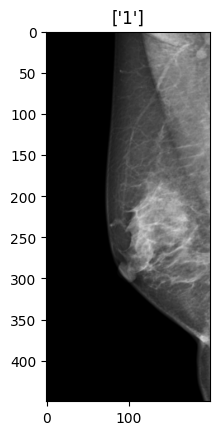

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [6]:
siamese50simclr = get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')
#siamese50simclr = get_feature_extractor(feature_extractor='resnet50', cotrain=False,simclr='pretrained/best-contrastive50-2024-03-15.pt')#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

siamese50simclr.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))

In [7]:
def Focal_loss(class_logits,  labels):
    if class_logits.numel() == 0:
        return class_logits.new_zeros([1])[0]

    N = class_logits.shape[0]
    K = class_logits.shape[1] 

    target = class_logits.new_zeros(N, K)
    target[range(len(labels)), labels] = 1
    loss = sigmoid_focal_loss(class_logits, target, reduction = 'mean')
    return loss 

In [8]:
 
siamese50simclr = siamese50simclr.to(device)
momentum = 0.9
lr = 1
optimizer_ft = optim.SGD([{'params': siamese50simclr.fc.parameters()}], lr=lr, momentum=momentum)
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn= Focal_loss
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in siamese50simclr.parameters():
    param.requires_grad = False
for param in siamese50simclr.fc.parameters():
    param.requires_grad = True

In [14]:
from sklearn.metrics import f1_score
# bestmodel = siamese50simclr
f1max = 0
for e in range(30):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in tqdm(dataloaders['train'], total= len(dataloaders['train'])):
        siamese50simclr.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = siamese50simclr(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)
    predlist = []
    labelist = []
    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = siamese50simclr(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
        labelist.append(labels.detach().cpu().numpy()*1)
        predlist.append(preds.detach().cpu().numpy())
        val_acc += torch.sum(preds == labels.data)
    labelist = np.concatenate(labelist).ravel()
    predlist = np.concatenate(predlist).ravel()
    f1 = f1_score(predlist, labelist, average ='macro')
    if(f1 >= f1max):
        f1max = f1
        print(f"New best mode at epoch {e}")
        today = date.today()
        torch.save(siamese50simclr.state_dict(), f'pretrained/best-classification-siamese50simclr_freeze-{today}.pt')
    torch.save(siamese50simclr.state_dict(), f'pretrained/last-classification-siamese50simclr_freeze-{today}.pt')
   

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'], "f1", f1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.07it/s]


New best mode at epoch 0
E0 With LR 1 training acc:  0.6692136704640178 Val acc:  0.669576059850374 traning loss:  0.032467778647904864 f1 0.16041822255414487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.08it/s]


New best mode at epoch 1
E1 With LR 1 training acc:  0.6699777716032231 Val acc:  0.6701995012468828 traning loss:  0.032292883879411684 f1 0.1670355242288591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.02it/s]


E2 With LR 1 training acc:  0.6692831342039456 Val acc:  0.669576059850374 traning loss:  0.03221890335076052 f1 0.16685780769550404


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.02it/s]


E3 With LR 1 training acc:  0.6701166990830786 Val acc:  0.6689526184538653 traning loss:  0.0320365193260357 f1 0.16236909780216865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.23it/s]


E4 With LR 1 training acc:  0.6699083078632954 Val acc:  0.6689526184538653 traning loss:  0.031972945039762196 f1 0.16038863976083703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.13it/s]


E5 With LR 1 training acc:  0.6707418727424285 Val acc:  0.6701995012468828 traning loss:  0.031850463434614944 f1 0.16698972949515403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.17it/s]


New best mode at epoch 6
E6 With LR 1 training acc:  0.6699777716032231 Val acc:  0.6652119700748129 traning loss:  0.031753081180389206 f1 0.18687152080085156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.00it/s]


New best mode at epoch 7
E7 With LR 1 training acc:  0.6699083078632954 Val acc:  0.6701995012468828 traning loss:  0.03185993509336573 f1 0.19208674297124315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.12it/s]


New best mode at epoch 8
E8 With LR 1 training acc:  0.6698388441233676 Val acc:  0.669576059850374 traning loss:  0.031612984500732244 f1 0.19955685610546198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.16it/s]


E9 With LR 1 training acc:  0.6707418727424285 Val acc:  0.6701995012468828 traning loss:  0.031545562115343914 f1 0.16698972949515403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.06it/s]


New best mode at epoch 10
E10 With LR 1 training acc:  0.671714365101417 Val acc:  0.6645885286783042 traning loss:  0.0315366581917662 f1 0.22544538908053185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.11it/s]


E11 With LR 1 training acc:  0.6722700750208391 Val acc:  0.6677057356608479 traning loss:  0.03147667797013732 f1 0.1898272858992904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.07it/s]


New best mode at epoch 12
E12 With LR 1 training acc:  0.6709502639622117 Val acc:  0.6652119700748129 traning loss:  0.031446064561274224 f1 0.23725516044772826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.21it/s]


E13 With LR 1 training acc:  0.6722700750208391 Val acc:  0.6683291770573566 traning loss:  0.03144903876204132 f1 0.19086087763055656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.05it/s]


E14 With LR 1 training acc:  0.6722700750208391 Val acc:  0.6689526184538653 traning loss:  0.03129594693300409 f1 0.19594271092397186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.12it/s]


E15 With LR 1 training acc:  0.6730341761600445 Val acc:  0.6708229426433915 traning loss:  0.03126971869542884 f1 0.22093202293202294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.08it/s]


New best mode at epoch 16
E16 With LR 1 training acc:  0.6748402333981661 Val acc:  0.662718204488778 traning loss:  0.03115527273398219 f1 0.24157222391824798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.04it/s]


E17 With LR 1 training acc:  0.6750486246179495 Val acc:  0.6677057356608479 traning loss:  0.031114098141096672 f1 0.2076058454240693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.08it/s]


E18 With LR 1 training acc:  0.6744929146985273 Val acc:  0.6589775561097256 traning loss:  0.031137266611122993 f1 0.20735734957841556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.13it/s]


E19 With LR 1 training acc:  0.6755348707974438 Val acc:  0.6677057356608479 traning loss:  0.03093788355369474 f1 0.19376583849905596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.01it/s]


E20 With LR 1 training acc:  0.6778271742150598 Val acc:  0.6664588528678305 traning loss:  0.03092406146853508 f1 0.21107373914986266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.16it/s]


New best mode at epoch 21
E21 With LR 1 training acc:  0.6776187829952764 Val acc:  0.6620947630922693 traning loss:  0.030821370082527243 f1 0.2953521962111291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.16it/s]


E22 With LR 1 training acc:  0.6750486246179495 Val acc:  0.6639650872817955 traning loss:  0.030721451574794185 f1 0.22927447648284177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.11it/s]


E23 With LR 1 training acc:  0.6756737982772992 Val acc:  0.6639650872817955 traning loss:  0.030641656899454695 f1 0.2244394164342201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.12it/s]


E24 With LR 1 training acc:  0.6801889413726036 Val acc:  0.6683291770573566 traning loss:  0.03062595120131986 f1 0.2550965530697721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.05it/s]


E25 With LR 1 training acc:  0.6822728535704362 Val acc:  0.6652119700748129 traning loss:  0.03039273197334917 f1 0.2796468216873746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.08it/s]


E26 With LR 1 training acc:  0.6831064184495693 Val acc:  0.6701995012468828 traning loss:  0.030419528856977022 f1 0.24476182158367968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.07it/s]


E27 With LR 1 training acc:  0.6844956932481244 Val acc:  0.6427680798004988 traning loss:  0.03035361285725876 f1 0.2874855004535452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.01it/s]


E28 With LR 1 training acc:  0.6819949986107252 Val acc:  0.6701995012468828 traning loss:  0.030341390386807585 f1 0.21738499516626977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:34<00:00, 13.12it/s]


E29 With LR 1 training acc:  0.6821339260905808 Val acc:  0.6652119700748129 traning loss:  0.030331746917544023 f1 0.2225117712701258


In [9]:
# bestmodel = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
bestmodel = get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
bestmodel.load_state_dict(torch.load('pretrained/best-classification-siamese50simclr-2024-03-19.pt'))
bestmodel.to(device)
clear_output()

In [10]:
test_acc = 0
predlist = []
labelist = []
problist = []
test_embeddings = torch.zeros((0, 2048))
fextractor = torch.nn.Sequential(*(list(bestmodel.children())[:-1]))
sedis = 0
for inputs, labels in dataloaders['test']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
# test_embeddings = np.array(test_embeddings)

In [11]:
sedis/dataset_sizes['test']

tensor(2.2483, device='cuda:0')

In [12]:
print("test_acc acc: ", test_acc / dataset_sizes['test'])

test_acc acc:  tensor(0.6608, device='cuda:0')


In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.756     0.840     0.796      2682
           1      0.393     0.345     0.367       934
           2      0.224     0.118     0.155       186
           3      0.329     0.164     0.219       152
           4      0.778     0.457     0.575        46

    accuracy                          0.661      4000
   macro avg      0.496     0.385     0.423      4000
weighted avg      0.631     0.661     0.642      4000



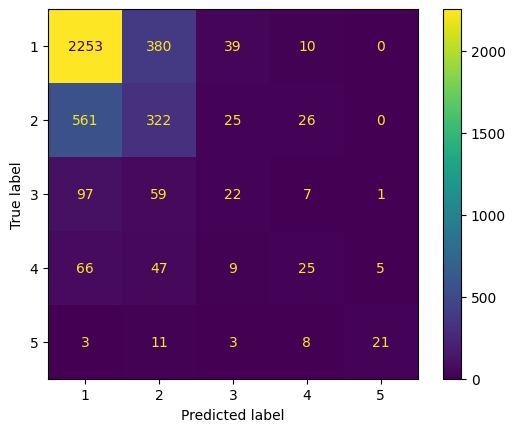

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [16]:
import sklearn.metrics as metrics

y_test = (labelist)
y_pred =(problist)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.grid(linestyle='--')
roc_auc_score(y_test, y_pred)

ValueError: multiclass format is not supported

# Similarity Comparison

In [2]:
datalne = {'train':100000, 'val':1000, 'test':2000}
image_datasets = {x: MammoCompDataset(phase=x, datalen=datalne[x], mode="binary_contrastive", seed =22) for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':8, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=8, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


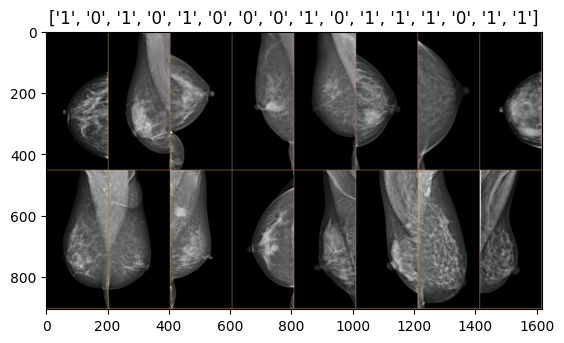

In [3]:

(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [4]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr= "/home/vishc1/hoang/simCLR-clone/runs/Mar21_17-27-27_huypn168/checkpoint_95_21032024.pth.tar" )
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        cosine_distance = torch.nn.functional.cosine_similarity(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        # loss_contrastive =  torch.nn.NLLLoss()(cosine_distance)

        return loss_contrastive

In [6]:
# from torch.optim import lr_scheduler
siamese50simclr = SiameseNetwork101().to(device)
momentum = 0
lr = 0.001
optimizer_ft = optim.SGD([{'params': siamese50simclr.cnn1.conv1.parameters()},
                        {'params': siamese50simclr.cnn1.layer1.parameters()},
                        {'params': siamese50simclr.cnn1.layer2.parameters()},
                        {'params': siamese50simclr.cnn1.layer3.parameters()},
                        {'params': siamese50simclr.cnn1.layer4.parameters()},
                        {'params': siamese50simclr.cnn1.fc.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = ContrastiveLoss(margin=2.0)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in siamese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in siamese50simclr.cnn1.fc.parameters():
    param.requires_grad = True

load simclr resnet


In [7]:
siamese50simclr

SiameseNetwork101(
  (cnn1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [8]:
valaccmax = 0
trainlosslist = []
trainacclist  = []
currloss = 1000000
for e in range(10):
    training_acc = 0
    val_acc = 0
    training_loss = 0.0
    val_loss = 0.0
    for inputs, labels, _ in tqdm(dataloaders['train'], total=len(dataloaders['train'])):
        siamese50simclr.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        output1, output2 = siamese50simclr(inputA, inputB)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss += loss.item()
        # training_acc += torch.sum(preds == labels.data)
    trainlosslist.append(training_loss)
        # trainacclist.append(training_acc)
        
    for inputs, labels, _ in dataloaders['val']:
        siamese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = siamese50simclr(inputA, inputB)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            loss = loss_fn(output1, output2, labels)
            val_loss += loss.item()
            # val_acc += torch.sum(preds == labels.data)
    val_loss= val_loss / dataset_sizes['val']
    if(val_loss < currloss):
        currloss = val_loss
        today = date.today()
        
        torch.save(siamese50simclr.state_dict(), f'pretrained/best-contrastive50-{today}.pt')

    #scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", "traning loss: ", training_loss / dataset_sizes['train'], "val loss: ", val_loss / dataset_sizes['val'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [16:25<00:00,  6.34it/s]


E0 With LR 0.001 training acc:  traning loss:  0.06254010039567948 val loss:  0.0001248630814552307


 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                               | 2142/6250 [05:37<10:46,  6.35it/s]


KeyboardInterrupt: 

In [8]:
plt.plot(torch.stack(val_loss).cpu()/1000)
# plt.plot(training_loss_test/1000)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not float

In [7]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('pretrained/best-supcontrastive50-2024-03-23.pt')
bestsimese50simclr.load_state_dict(state_dict)

load simclr resnet


<All keys matched successfully>

In [8]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsimese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = bestsimese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.000108
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.819794
[t-SNE] KL divergence after 1000 iterations: 0.589438


/tmp/ipykernel_821062/3429489112.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


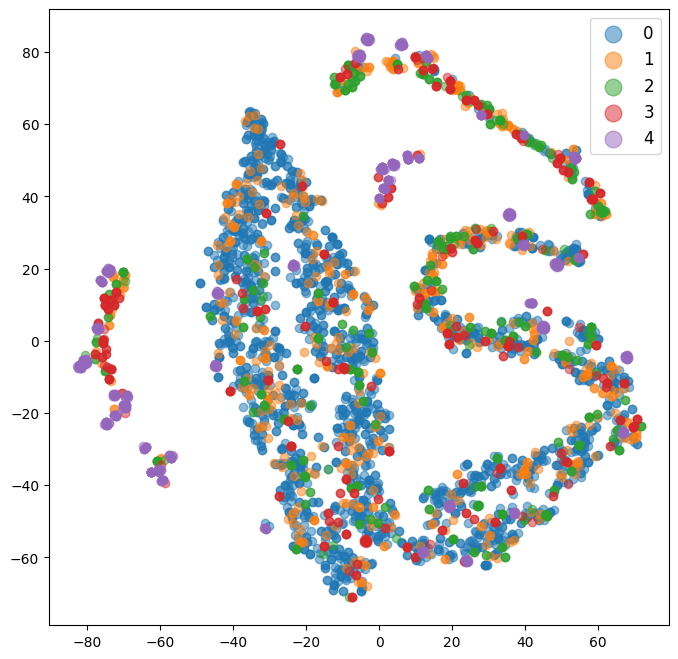

In [10]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=30, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Prefered Comparison

In [2]:

datalne = {'train':100000, 'val':1000, 'test':2000}
image_datasets = {x: MammoCompDataset( phase=x, datalen=datalne[x], mode="severity_comparison", seed=22) for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':8, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=8)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


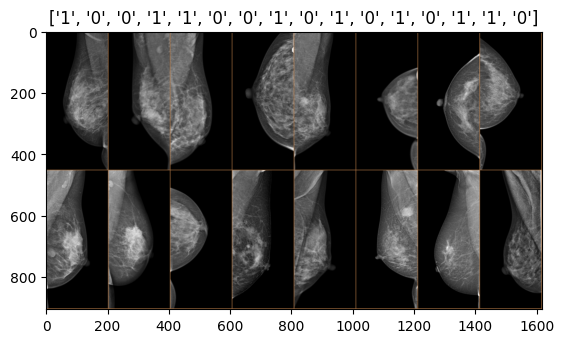

In [3]:
(inputs, _), _, classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [4]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False)# , simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [5]:
class SeverityModel(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self, path2pretrained='pretrained/best-contrastive50-2024-03-22.pt'):
        super(SeverityModel, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.bestsimese50simclr = SiameseNetwork101()
        state_dict = torch.load(path2pretrained)
        self.bestsimese50simclr.load_state_dict(state_dict)
        self.bestsimese50simclr.cnn1.add_module('fc2',
            nn.Sequential(torch.nn.Linear(256, 256),
                          torch.nn.ReLU(),
                        torch.nn.Dropout(0.1),
                        torch.nn.Linear(256, 256)))
    
    def forward_once(self, x):
        output = self.bestsimese50simclr.cnn1.fc2(self.bestsimese50simclr.cnn1(x))
        return output

    def forward(self, input1, input2, refinput):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        refinput = self.bestsimese50simclr.cnn1(refinput)
        return output1, output2, refinput

In [6]:
class PreferenceComparisonLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(PreferenceComparisonLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, ref):
        # euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        cosine_distanceA = torch.nn.functional.cosine_similarity(output1, ref)
        cosine_distanceB = torch.nn.functional.cosine_similarity(output2, ref)
        loss_comparation = torch.nn.NLLLoss()(torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB), label)
        # loss_comparation = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))

        return loss_comparation

In [7]:
smodel = SeverityModel(path2pretrained='pretrained/best-contrastive50-2024-03-22.pt').to(device)
momentum = 0
lr = 0.01
optimizer_ft = optim.SGD([{'params': smodel.bestsimese50simclr.cnn1.conv1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer1.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer2.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer3.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.layer4.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc.parameters()},
                        {'params': smodel.bestsimese50simclr.cnn1.fc2.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
loss_fn = PreferenceComparisonLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in smodel.bestsimese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in smodel.bestsimese50simclr.cnn1.fc2.parameters():
    param.requires_grad = True

In [8]:
valaccmax = 0
trainlosslist = []
trainacclist  = []

In [9]:
# valaccmax = 0
# trainlosslist = []
# trainacclist  = []
# torch.set_grad_enabled(True)
for e in range(10):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    curr_loss = 100
    for inputs,ref, labels, _ in tqdm(dataloaders['train']):
        smodel.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        #ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
        #ref = torch.stack(ref).to(device)
        ref = ref.to(device)
        output1, output2, refimg = smodel(inputA, inputB, ref)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels, refimg)
        # cosine_distanceA = torch.nn.functional.cosine_similarity(output1, refimg)
        # cosine_distanceB = torch.nn.functional.cosine_similarity(output2, refimg)
        # gamma = torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB)
        # loss = torch.nn.NLLLoss()(gamma, labels)
        # loss.requires_grad = True
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        # training_acc += torch.sum(preds == labels.data)
        # trainlosslist.append(training_loss_test)
        # trainacclist.append(training_acc)
        
    # for inputs, labels in dataloaders['val']:
    #     smodel.eval()
    #     inputA = inputs[0].to(device)
    #     inputB = inputs[1].to(device)
    #     labels = labels.to(device)

    #     with torch.no_grad():
    #         output1, output2 = siamese50simclr(inputA, inputB)
    #         preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
    #         # loss = loss_fn(inputA, inputB, labels)
    #         val_acc += torch.sum(preds == labels.data)

    if(training_loss_test < curr_loss):
        curr_loss = training_loss_test
        today = date.today()
        torch.save(smodel.state_dict(), f'pretrained/best-smodel50-wofreeze-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}", "traning loss: ", training_loss_test / dataset_sizes['train'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [26:30<00:00,  3.93it/s]


E0 With LR 0.01 traning loss:  -0.032077235834896564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [26:31<00:00,  3.93it/s]


E1 With LR 0.01 traning loss:  -0.0328440879663825


  0%|▊                                                                                                                                                                                                                                                                                  | 18/6250 [00:06<34:37,  3.00it/s]


KeyboardInterrupt: 

In [6]:
bestsmodel = SeverityModel(path2pretrained='pretrained/best-contrastive50-2024-03-22.pt').to(device)
state_dict = torch.load('/home/vishc1/hoang/pseudopapill/pretrained/best-smodel50-wofreeze-2024-03-24.pt')
bestsmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
torch.multiprocessing.set_sharing_strategy('file_system')
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, ref, labels, args in dataloaders['test']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            #ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = ref.to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.001s...
[t-SNE] Computed neighbors for 6000 samples in 0.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.000002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.479187
[t-SNE] KL divergence after 1000 iterations: 0.410193


/tmp/ipykernel_838195/907591532.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


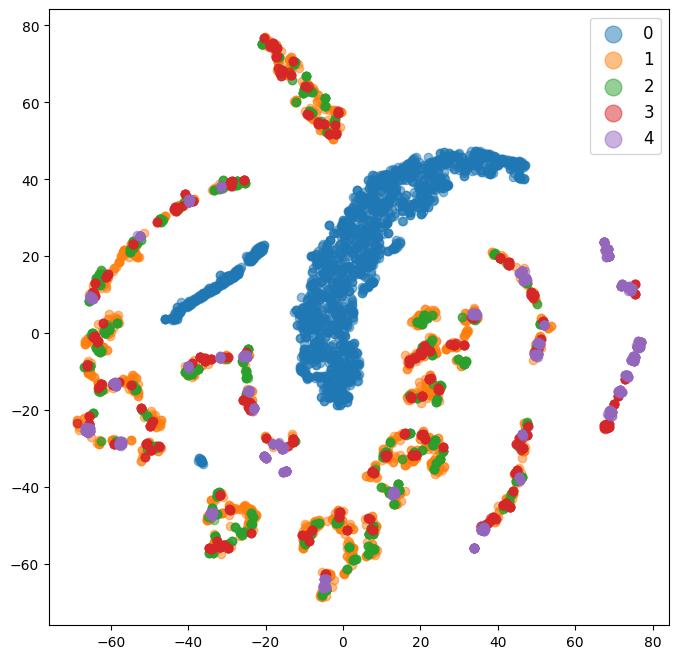

In [8]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=50, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Explainable AI

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from captum.attr import IntegratedGradients, LimeBase
from captum.attr import GradientShap, KernelShap, FeatureAblation, FeaturePermutation,ShapleyValueSampling
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [18]:
X, y, meta = image_datasets['train'][50]

In [19]:
meta

(1, 4)

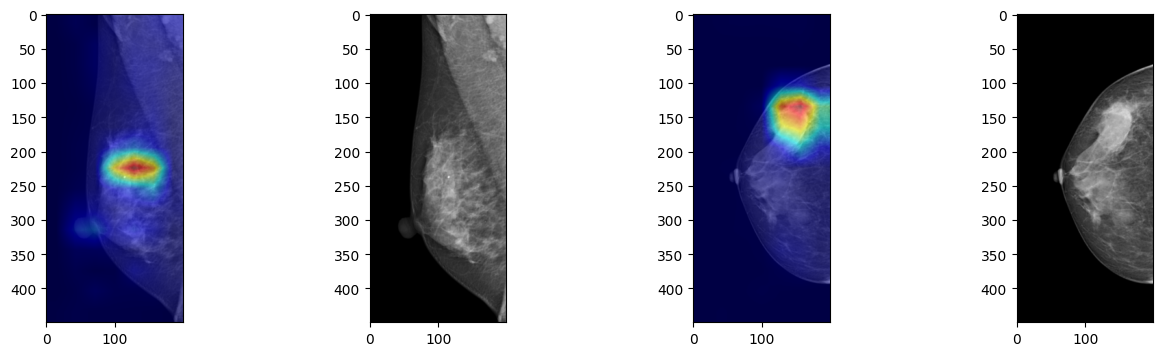

In [21]:
# X,y,_ = image_datasets[4]
model = smodel.bestsimese50simclr.cnn1.cpu()
target_layers = [model.layer4[-1]]

# input_tensor = data_transforms['test'](Image.open("./datasets/longtitude/90007-L/90007-LU306-L.jpg")).unsqueeze(0) # Create an input tensor image for your model..
input_tensorA = X[0].unsqueeze(0)
input_tensorB = X[1].unsqueeze(0)

# Note: input_tensor can be a batch tensor with several images!
rgb_imgA = imgtensor2array(input_tensorA[0], mean=mean, std=std)
rgb_imgB = imgtensor2array(input_tensorB[0], mean=mean, std=std)
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

input_tensorA.requires_grad = True
input_tensorB.requires_grad = True
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_camA = cam(input_tensor=input_tensorA)
grayscale_camB = cam(input_tensor=input_tensorB)
# In this example grayscale_cam has only one image in the batch:

visualizationA = show_cam_on_image(rgb_imgA, grayscale_camA[0, :], use_rgb=True)
visualizationB = show_cam_on_image(rgb_imgB, grayscale_camB[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(visualizationA, label= 'heatmap A')
ax[1].imshow(rgb_imgA, label= 'heatmap A')
ax[2].imshow(visualizationB, label= 'heatmap A')
ax[3].imshow(rgb_imgB, label= 'heatmap A')

# Preference and Comparison

In [16]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':10000, 'val':1000, 'test':1000}
image_datasets = {x: PapilSeverityDataset( phase=x, datalen=datalne[x], mode="preference_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1','2']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

NameError: name 'PapilSeverityDataset' is not defined

In [ ]:
(inputs, _), classes, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [ ]:
class PreferenceContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(PreferenceContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, ref):
        total_loss = 0
        for i in label:
            # cosine_distanceA = torch.nn.functional.cosine_similarity(output1[i], ref)
            # cosine_distanceB = torch.nn.functional.cosine_similarity(output2[i], ref)
            # cosine_distance = torch.nn.functional.cosine_similarity(output1[i], output2[i])
            if(i == 2):
                cosine_distance = torch.nn.functional.cosine_similarity(output1[i], output2[i])
                total_loss = total_loss + (i) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2)
            else:
                cosine_distanceA = torch.nn.functional.cosine_similarity(output1[i], ref)
                cosine_distanceB = torch.nn.functional.cosine_similarity(output2[i], ref)
                total_loss = total_loss + torch.nn.CrossEntropyLoss()(torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB), i) 

        return total_loss/len(label)

In [ ]:
smodel = SeverityModel().to(device)
momentum = 0
lr = 0.05
optimizer_ft = optim.SGD([{'params': smodel.bestsimese50simclr.cnn1.parameters()}], lr=lr, momentum=momentum)
loss_fn = PreferenceComparisonLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

for param in smodel.bestsimese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in smodel.bestsimese50simclr.cnn1.fc2.parameters():
    param.requires_grad = True

In [ ]:
valaccmax = 0
trainlosslist = []
trainacclist  = []

In [ ]:
for e in range(10):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    curr_loss = 0
    for inputs, labels, _ in dataloaders['train']:
        smodel.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
        ref = torch.stack(ref).to(device)
        output1, output2, refimg = smodel(inputA, inputB, ref)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels, refimg)
        # cosine_distanceA = torch.nn.functional.cosine_similarity(output1, refimg)
        # cosine_distanceB = torch.nn.functional.cosine_similarity(output2, refimg)
        # gamma = torch.nn.Sigmoid()(cosine_distanceA - cosine_distanceB)
        # loss = torch.nn.NLLLoss()(gamma, labels)
        # loss.requires_grad = True
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        # training_acc += torch.sum(preds == labels.data)
        trainlosslist.append(training_loss_test)
        trainacclist.append(training_acc)
        
    # for inputs, labels in dataloaders['val']:
    #     smodel.eval()
    #     inputA = inputs[0].to(device)
    #     inputB = inputs[1].to(device)
    #     labels = labels.to(device)

    #     with torch.no_grad():
    #         output1, output2 = siamese50simclr(inputA, inputB)
    #         preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
    #         # loss = loss_fn(inputA, inputB, labels)
    #         val_acc += torch.sum(preds == labels.data)

    if(training_loss_test < curr_loss):
        curr_loss = training_loss_test
        torch.save(smodel.state_dict(), './pretrained/best-combine-smodel-wofreeze.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}", "traning loss: ", training_loss_test / dataset_sizes['train'])

In [ ]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/best-combine-smodel-wofreeze.pt')
bestsmodel.load_state_dict(state_dict)

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = torch.stack(ref).to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=30, early_exaggeration=10, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Multiclass Contrastive Learning

In [2]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr= "/home/vishc1/hoang/simCLR-clone/runs/Mar21_17-27-27_huypn168/checkpoint_95_21032024.pth.tar" )
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        #                               (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        cosine_distance = torch.nn.functional.cosine_similarity(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(cosine_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2))
        # loss_contrastive =  torch.nn.NLLLoss()(cosine_distance)

        return loss_contrastive

In [3]:
datalne = {'train':100000, 'val':1000, 'test':2000}
image_datasets = {x: MammoCompDataset( phase=x, datalen=datalne[x], mode="multiclass_contrastive", seed=22) for x in ['train', 'val', 'test']}
batch_size = {'train':16, 'val':8, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=8)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


In [4]:
siamese50simclr = SiameseNetwork101().to(device)
momentum = 0
lr = 0.1
# optimizer_ft = optim.SGD([{'params': siamese50simclr.cnn1.conv1.parameters()},
#                         {'params': siamese50simclr.cnn1.layer1.parameters()},
#                         {'params': siamese50simclr.cnn1.layer2.parameters()},
#                         {'params': siamese50simclr.cnn1.layer3.parameters()},
#                         {'params': siamese50simclr.cnn1.layer4.parameters()},
#                         {'params': siamese50simclr.cnn1.fc.parameters(), 'lr':lr*10}], lr=lr, momentum=momentum)
optimizer_ft = optim.SGD(siamese50simclr.parameters(), lr = lr, momentum= momentum)

loss_fn = ContrastiveLoss(margin=2.0)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.5)

for param in siamese50simclr.cnn1.parameters():
    param.requires_grad = True
for param in siamese50simclr.cnn1.fc.parameters():
    param.requires_grad = True

load simclr resnet


In [5]:
valaccmax = 0
trainlosslist = []
trainacclist  = []
currloss = 100000
for e in range(5):
    training_acc = 0
    val_acc = 0
    training_loss = 0.0
    val_loss = 0.0
    for inputs, labels, _ in tqdm(dataloaders['train']):
        siamese50simclr.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        output1, output2 = siamese50simclr(inputA, inputB)
        # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss += loss.item()
        # training_acc += torch.sum(preds == labels.data)
    # trainlosslist.append(training_loss)
        # trainacclist.append(training_acc)
        
    for inputs, labels, _ in dataloaders['val']:
        siamese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = siamese50simclr(inputA, inputB)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            loss = loss_fn(output1, output2, labels)
            val_loss += loss.item()
            # val_acc += torch.sum(preds == labels.data)

    if(val_loss < currloss):
        currloss = val_loss
        today = date.today()
        torch.save(siamese50simclr.state_dict(), f'pretrained/best-multiclass-contrastive50-{today}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", "traning loss: ", training_loss / dataset_sizes['train'], "val loss: ", val_loss / dataset_sizes['val'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [18:29<00:00,  5.64it/s]


E0 With LR 0.001 training acc:  traning loss:  0.06283866454601288 val loss:  0.1250770732164383


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [18:17<00:00,  5.69it/s]


E1 With LR 0.0005 training acc:  traning loss:  0.06263140775382518 val loss:  0.12504248833656312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [18:17<00:00,  5.69it/s]


E2 With LR 0.0005 training acc:  traning loss:  0.06260304544329644 val loss:  0.1250349485874176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [18:17<00:00,  5.70it/s]


E3 With LR 0.00025 training acc:  traning loss:  0.06259204488277435 val loss:  0.1250302702188492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [18:18<00:00,  5.69it/s]


E4 With LR 0.00025 training acc:  traning loss:  0.06258544266939163 val loss:  0.12502789121866226


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 3581/6250 [10:29<07:49,  5.69it/s]


KeyboardInterrupt: 

In [6]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('pretrained/best-multiclass-contrastive50-2024-03-25.pt')
bestsimese50simclr.load_state_dict(state_dict)

load simclr resnet


<All keys matched successfully>

In [8]:
torch.multiprocessing.set_sharing_strategy('file_system')
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsimese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = bestsimese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.000143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.184937
[t-SNE] KL divergence after 1000 iterations: 0.658867


/tmp/ipykernel_42280/3429489112.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


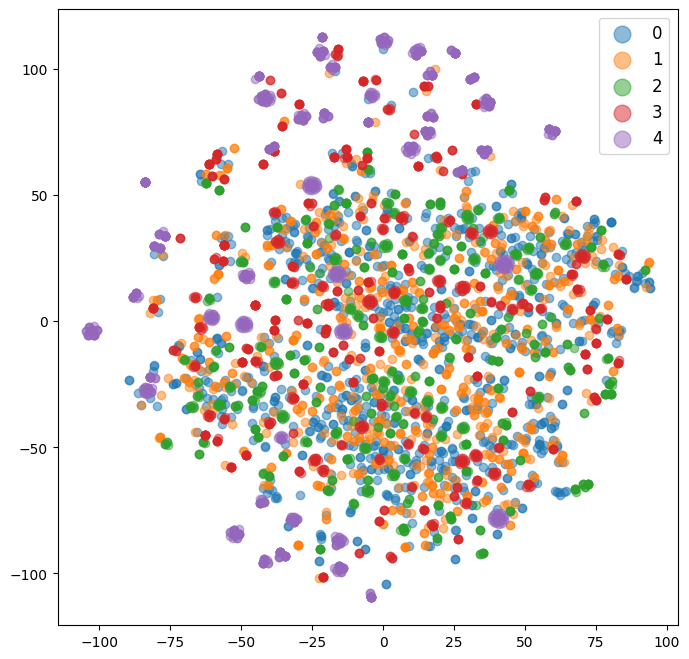

In [9]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=30, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()